In [49]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

내용을 아래와 같이 잘라야 함.

- Part 1. 부채사이클 기반 2025년 리세션 리스크 분석
- Part 2. 통화량 기반 비트코인 벨류에이션

## Step 1. 데이터 수집 및 전처리

### 1-1. Fred api
- m0,m1,m2,통화승수

In [2]:
from fredapi import Fred
import os

# FRED API 호출
FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred(api_key=FRED_API_KEY)
start_date = '1980-01-01'
end_date = '2024-12-31'

# 통화량
m0 = fred.get_series("BOGMBASE") # M0
m1 = fred.get_series("M1SL") # M1
m2 = fred.get_series("M2SL") # M2
m1_to_m0 = m1 / m0 
m2_to_m0 = m2 / m0

### 1-2. coinmarketcap - bitcoin price, supply, market cap
- 비트코인 가격 시총, 공급량 데이터 

In [ ]:
url = "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id=1&timeStart=1633910400&timeEnd=1704931200"
res = requests.get(url)
bitcoin_price = res.json()['data']['points']
data_bitcoin_mc = {datetime.fromtimestamp(int(k)):v['v'] for k,v in bitcoin_price.items()}
df_bitcoin_mc =pd.DataFrame(index=data_bitcoin_mc.keys(), data=data_bitcoin_mc.values(), 
                            columns=['price', 'volume', 'market_cap','-','supply'])
df_bitcoin_mc

,price,volume,market_cap,-,supply
2010-07-14 09:00:00,0.058157,2.615400e+02,1.961800e+05,1.0,3373269.0
2010-07-22 09:00:00,0.074179,2.167060e+03,2.584294e+05,1.0,3483875.0
2010-07-30 09:00:00,0.063739,3.013580e+03,2.269748e+05,1.0,3561029.0
2010-08-06 09:00:00,0.060768,1.397310e+03,2.210160e+05,1.0,3637025.0
2010-08-14 09:00:00,0.062908,4.404590e+03,2.340858e+05,1.0,3721075.0
...,...,...,...,...,...
2024-12-17 09:00:00,106030.690582,6.858936e+10,2.099169e+12,1.0,19797746.0
2024-12-25 09:00:00,98675.910863,3.370039e+10,1.953869e+12,1.0,19800867.0
2025-01-01 09:00:00,93425.102136,2.451989e+10,1.850152e+12,1.0,19803590.0
2025-01-09 09:00:00,95043.487640,6.277726e+10,1.882874e+12,1.0,19810653.0


### 1-3. world gold council - gold price, mine production, mine total
- 금 채굴량, 온스당 가격

In [4]:
url = 'https://fsapi.gold.org/api/v11/charts/supply-and-demand/35'
res = requests.get(url)
data_gld_mc = res.json()['chartData']['Supply_Quarterly']
df_gld_mc = pd.DataFrame({
    'date':data_gld_mc['categories'],
    'mine_production':data_gld_mc['series'][0]['data'],
    'price/oz': data_gld_mc['series'][-1]['data']
})
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : '20'+x[-2:]+x[:2])
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : pd.Period(x, freq='Q').to_timestamp())
df_gld_mc = df_gld_mc.set_index('date')
df_gld_mc.head()

,mine_production,price/oz
date,,
2010-01-01,632.000,1109.1
2010-04-01,674.598,1196.7
2010-07-01,729.703,1226.8
2010-10-01,718.165,1366.8
2011-01-01,667.553,1386.3


25.1 기준,
- 1t은 35274oz
- 연간 채굴량 약 3600t(분기별 900t)
- oz로 환산하면 연간 1,269,842,400oz, 분기별 31,746,600oz
- 현재(25.1.3 기준) 금은 온스(oz)당 2,634$
- 현재(25 기준) 총 금 채굴량 201,296t, 온스로 환산하면 7,100,515,104
- 시가총액은 18,702,756,783,936$  (18 trillion dollar)


2009년 까지 과거 금 누적생산량

In [6]:
data_gld_prod = requests.get('https://api.ourworldindata.org/v1/indicators/66252.data.json').json()
data_gld_prod_values = data_gld_prod['values']
data_gld_prod_entities = data_gld_prod['entities']
data_gld_prod_years = data_gld_prod['years']
print(len(data_gld_prod_values), len(data_gld_prod_entities), len(data_gld_prod_years))
df_gld_prod = pd.DataFrame(data={
    'years':data_gld_prod_years,
    'entities': data_gld_prod_entities, 
    'values': data_gld_prod_values})
df_gld_prod.head()

36478 36478 36478


,years,entities,values
0,1681,153,0
1,1681,155,0
2,1681,157,0
3,1681,159,0
4,1681,160,0


In [50]:
df_gld_prod

,years,entities,values
0,1681,153,0
1,1681,155,0
2,1681,157,0
3,1681,159,0
4,1681,160,0
...,...,...,...
36473,2015,202,1
36474,2015,234,30
36475,2015,238,2
36476,2015,253,1


- https://ourworldindata.org/grapher/gold-production

- 과거 기간 퐘, 총 채굴량

In [8]:
df_gld_prod_total = (df_gld_prod.groupby('years').agg('sum')/2).cumsum().loc[2009]['values']
df_gld_mc['mine_total'] = df_gld_mc['mine_production'].cumsum() + df_gld_prod_total
df_gld_mc.head()

,mine_production,price/oz,mine_total
date,,,
2010-01-01,632.000,1109.1,143529.000
2010-04-01,674.598,1196.7,144203.598
2010-07-01,729.703,1226.8,144933.301
2010-10-01,718.165,1366.8,145651.466
2011-01-01,667.553,1386.3,146319.019


In [10]:
oz_to_ton = 35274
df_gld_mc['market_cap'] = df_gld_mc['price/oz']*df_gld_mc['mine_total']*oz_to_ton
df_gld_mc.head()

,mine_production,price/oz,mine_total,market_cap
date,,,,
2010-01-01,632.000,1109.1,143529.000,5.615198e+12
2010-04-01,674.598,1196.7,144203.598,6.087179e+12
2010-07-01,729.703,1226.8,144933.301,6.271864e+12
2010-10-01,718.165,1366.8,145651.466,7.022222e+12
2011-01-01,667.553,1386.3,146319.019,7.155051e+12


In [401]:
df_gld_mc

,mine_production,price/oz,mine_total,market_cap
date,,,,
2010-01-01,632.000,1109.1,143529.000,5.615198e+12
2010-04-01,674.598,1196.7,144203.598,6.087179e+12
2010-07-01,729.703,1226.8,144933.301,6.271864e+12
2010-10-01,718.165,1366.8,145651.466,7.022222e+12
2011-01-01,667.553,1386.3,146319.019,7.155051e+12
2011-04-01,719.680,1506.1,147038.699,7.811603e+12
2011-07-01,752.679,1702.1,147791.378,8.873376e+12
2011-10-01,736.950,1688.0,148528.328,8.843750e+12
2012-01-01,685.842,1690.6,149214.170,8.898271e+12


## Step 2. 연도별 달러 통화, 금, 비트코인 증가 추이

### 2-1. 전기간 통화량

m2가 최근 기준
- 참고) 우리나라의 경우 1979년까지 주로 M1을 기준으로 통화량을 관리했다. 이후 경제 규모가 커지고 다양한 금융기관이 출현하면서 M1이 실물경제의 동향을 제대로 반영하지 못한다고 판단돼 M2를 기준 통화지표로 사용하고 있다. M1은 측정이 정확하고 편리한 장점이 있지만, 실물경제의 규모를 정확히 반영하지 못하는 문제가 발생해 우리나라를 비롯한 많은 나라에서 M2를 기준 통화지표로 사용하고 있다. 최근에는 금융의 발전으로 가상화폐를 비롯해 금융상품이 더 다양해지고 있다. 그뿐 아니라 금융시장의 구조도 급격히 변해가는 상황에서 M2도 실물경제와 괴리가 많이 발생하고 있어 한층 더 포괄적인 통화지표를 사용해야 한다는 주장이 제기되고 있다.

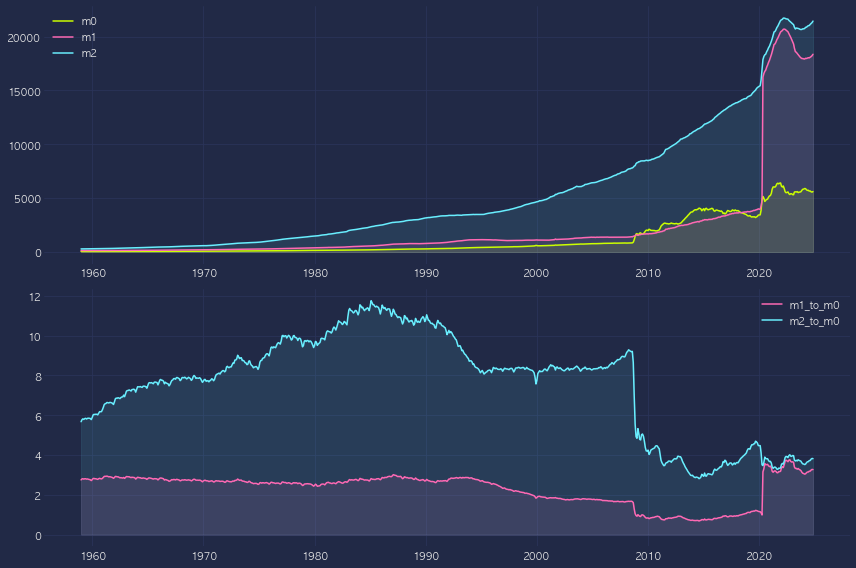

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

sns.lineplot(data=m0,x=m0.index,y=m0.values,ax=axes[0], label='m0', color='#CCFF00')
axes[0].fill_between(x=m0.index, y1=0, y2=m0.values, alpha=0.1, color='#CCFF00')
sns.lineplot(data=m1,x=m1.index,y=m1.values,ax=axes[0], label='m1', color='#FF69B4')
axes[0].fill_between(x=m1.index, y1=0, y2=m1.values, alpha=0.1, color='#FF69B4')
sns.lineplot(data=m2,x=m2.index,y=m2.values,ax=axes[0], label='m2', color='#69EFFF')
axes[0].fill_between(x=m2.index, y1=0, y2=m2.values, alpha=0.1, color='#69EFFF')

sns.lineplot(data=m1_to_m0,x=m1_to_m0.index,y=m1_to_m0.values,ax=axes[1], label='m1_to_m0', color='#FF69B4')
axes[1].fill_between(x=m1_to_m0.index, y1=0, y2=m1_to_m0.values, alpha=0.1, color='#FF69B4')
sns.lineplot(data=m2_to_m0,x=m2_to_m0.index,y=m2_to_m0.values,ax=axes[1], label='m2_to_m0', color='#69EFFF')
axes[1].fill_between(x=m2_to_m0.index, y1=0, y2=m2_to_m0.values, alpha=0.1, color='#69EFFF')


plt.tight_layout()
plt.show()

통화승수 하락 요인:
- 높은 지급준비율
- 경제 불확실성 및 금융 위기
- 중앙은행의 긴축적 통화정책
- 은행들의 지급준비금 선호 증가

통화 승수 하락 시:
- 유동성 함정(Liquidity Trap):
    - 중앙은행이 본원통화를 늘려도 은행들이 대출을 줄이고 준비금을 쌓아두면, 경제 전체의 통화량이 증가하지 않아 경기 부양 효과가 제한됩니다.
- 경제 성장 둔화:
    - 신용 창출이 줄어들어 기업과 개인의 대출 접근성이 낮아지고, 투자와 소비가 위축되어 경제 성장률이 둔화될 수 있습니다.
- 디플레이션 위험:
    - 통화량 증가가 제한되면 수요 감소로 인해 가격이 하락(디플레이션)할 위험이 높아집니다.

2020 돈을 대규모로 풀었고, m0대비 m1 통화승수는 증가했으나 m0 대비 m2 통화승수는 그렇지 않다.
돈을 풀어서 은행에 단기예금으로 많이 유입되었으나, 장기 예금이나 적금 등 은행 예치 상품으로 묶기보다 비은행 금융 자산으로 이동하고 있음.

- M1 승수의 급격한 증가는 사람들이 현금을 덜 보유하고 요구불예금과 같은 단기 거래 수단을 선호하고 있음을 나타내며, 이는 거래와 소비가 활발해지고 있음을 반영합니다.
- M2 승수의 감소 또는 정체는 자금이 은행 중심의 장기 예금에서 벗어나 비은행 금융 자산으로 이동하고 있다는 신호로, 이는 금융 시장의 성장과 동시에 전통적인 은행 시스템의 축소를 의미합니다.


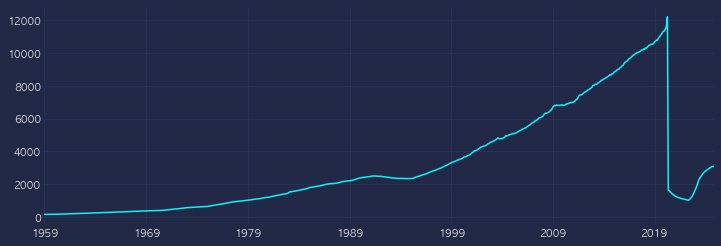

In [55]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

(m2 - m1).plot(ax=axes, label='m2 - m1')
plt.show()

- 유동성이 다소 떨어지는, 저축성 예금을 포함하는 광의통화(m2)과 실질 통화량을 반영.
- 광의통화의 변화량은 왜 적을까? 저축성 예금보다 투자처로 많이 흘러들어갔을 것.
- 아래 차트에서 2020년 이후 m2에서 m1을 제외한, 유동성이 낮은 저축성 예금 잔고가 급격히 떨어지는 모습을 볼 수 있다.
- 저축성 예금을 시중 통화량에서 제외하는 것은 비약이 크기 때문에 포함해서 금, 비트코인 가치평가에 활용해야.

### 2-2. 2010년 이후 통화, 금, 비트코인 유동성

- 비트코인은 유통량이 2100만개로 제한되어 있으며 25년 기준 약 1980만개로, 약 95%, 거의 도달해있는 상태
- 2020년은 비트코인 반감기이자 코로나 양적완화로 미국 달러에 대한 체질이 크게 변화한 시기다. 이 기점 이전 데이터로 비트코인 가치를 계산하기는 무리

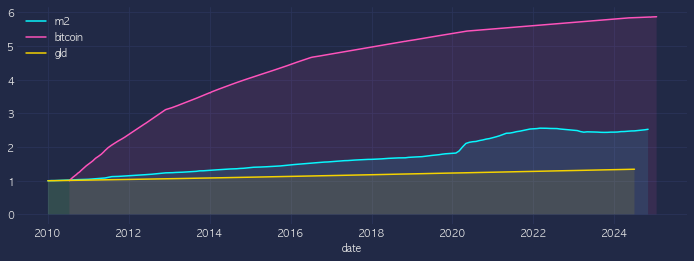

In [57]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

data_m2 = (m2['2010':] / m2['2010':].iloc[0])
sns.lineplot(data=data_m2, x=data_m2.index, y=data_m2.values, ax=axes, label='m2')
axes.fill_between(x=data_m2.index, y1=0, y2=data_m2.values, alpha=0.1)

data_bitcoin = (df_bitcoin_mc['supply']['2010':] / df_bitcoin_mc['supply']['2010':].iloc[0])
sns.lineplot(data=data_bitcoin, x=data_bitcoin.index, y=data_bitcoin.values, ax=axes, label='bitcoin')
axes.fill_between(x=data_bitcoin.index, y1=0, y2=data_bitcoin.values, alpha=0.1)

data_gld = (df_gld_mc['mine_total'] / df_gld_mc['mine_total'].iloc[0])
sns.lineplot(data=data_gld, x=data_gld.index, y=data_gld.values, ax=axes, label='gld')
axes.fill_between(x=data_gld.index, y1=0, y2=data_gld.values, alpha=0.1)

plt.show()

## Step 3. 유동성 비율을 통한 금 가격 추정

### 3-1. 금 증가량 대비 통화 증가량으로 추정

- 금 증가량 대비 통화 증가량
    - 금보다 통화가 빠르게 증가하면 금의 가격이 상승할 것이다.

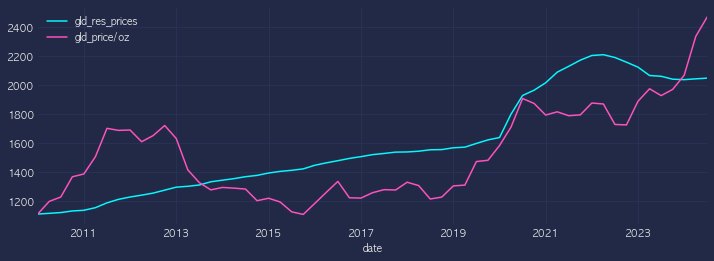

In [92]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

gld_res_prices = (data_m2 / data_gld).dropna() * df_gld_mc['price/oz'].iloc[0]

gld_res_prices.plot(ax=ax, label='gld_res_prices')
df_gld_mc['price/oz'].plot(ax=ax, label='gld_price/oz')

plt.legend()
plt.show()

In [403]:
(data_m2 / data_gld).dropna()

2010-01-01    1.000000
2010-04-01    1.004373
2010-07-01    1.009210
2010-10-01    1.019217
2011-01-01    1.023418
2011-04-01    1.039732
2011-07-01    1.069753
2011-10-01    1.091733
2012-01-01    1.106275
2012-04-01    1.117750
2012-07-01    1.130679
2012-10-01    1.149176
2013-01-01    1.167626
2013-04-01    1.173124
2013-07-01    1.181155
2013-10-01    1.201327
2014-01-01    1.211155
2014-04-01    1.220876
2014-07-01    1.232970
2014-10-01    1.241113
2015-01-01    1.255933
2015-04-01    1.266129
2015-07-01    1.272852
2015-10-01    1.281756
2016-01-01    1.304187
2016-04-01    1.319411
2016-07-01    1.332809
2016-10-01    1.347026
2017-01-01    1.358007
2017-04-01    1.370572
2017-07-01    1.377948
2017-10-01    1.386319
2018-01-01    1.387415
2018-04-01    1.392027
2018-07-01    1.400844
2018-10-01    1.402065
2019-01-01    1.413273
2019-04-01    1.417352
2019-07-01    1.440511
2019-10-01    1.462589
2020-01-01    1.477363
2020-04-01    1.623354
2020-07-01    1.739616
2020-10-01 

### 3-2. 추정 방식의 유효성 평가

- 이런 추정 방식이 유효한가? 

In [216]:
pd.DataFrame(data={
    'gld_res_prices':gld_res_prices,
    'gld_price':df_gld_mc['price/oz']}).corr()

,gld_res_prices,gld_price
gld_res_prices,1.000000,0.698404
gld_price,0.698404,1.000000


In [299]:
correlation = np.corrcoef(gld_res_prices, df_gld_mc['price/oz'])[0, 1]
correlation_lagged = np.corrcoef(gld_res_prices.shift(1).dropna(), df_gld_mc['price/oz'].shift(-1).dropna())[0, 1]

print(f"동시점 상관계수: {correlation}")
print(f"시차 상관계수: {correlation_lagged}")


동시점 상관계수: 0.6984043151015357
시차 상관계수: 0.6810169830790547


In [307]:
from sklearn.linear_model import LinearRegression

X = (data_m2/data_gld).dropna().values.reshape(-1,1)
y = df_gld_mc['price/oz']

lr = LinearRegression()
lr.fit(X, y)

print(f'slope:{lr.coef_[0]:.2f}')
print(f'intercept:{lr.intercept_:.2f}')
print(f'r^2:{lr.score(X,y):.2f}')

slope:705.55
intercept:512.64
r^2:0.49


In [304]:
lr.score(X,y)

0.48776858735244477

- r^2: 0.49 --> 단일 변수임을 고려했을 때 높은 설명력.

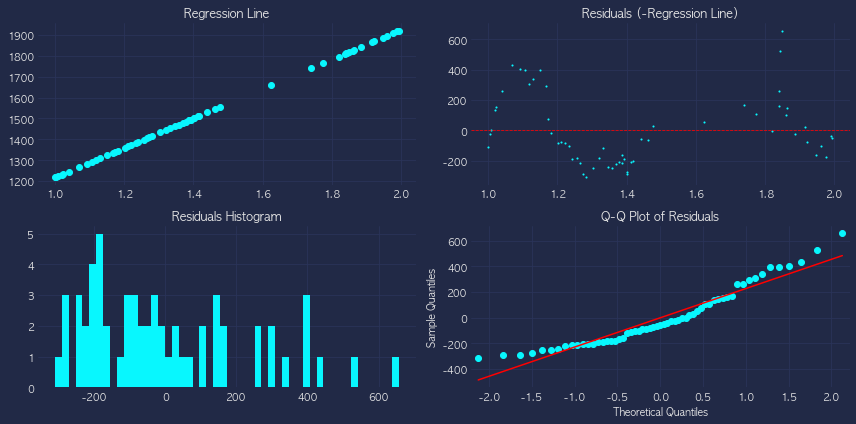

In [397]:
import statsmodels.api as sm

# 예측값 계산
y_pred = lr.predict(X)

# 잔차 계산
residuals = y - y_pred

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6))

axes[0,0].scatter(x=X.reshape(1,-1)[0], y=y_pred)
axes[0,0].set_title("Regression Line")

axes[0,1].scatter(x=X.reshape(1,-1)[0], y=residuals, s=1.2)
axes[0,1].axhline(0, color='red', linestyle='--', linewidth=0.8)
axes[0,1].set_title("Residuals (-Regression Line)")

axes[1,0].hist(residuals, bins=50)
axes[1,0].set_title("Residuals Histogram")
sm.qqplot(residuals, line='s', ax=axes[1,1])
axes[1,1].set_title("Q-Q Plot of Residuals")


plt.tight_layout()
plt.show()

잔차(Residuals)
- 잔차=실제값−예측값으로 계산됩니다.
- 잔차들이 x축에 대해 무작위로 분포해야 이상적인 회귀 모델입니다.
- 하지만 여기서는 잔차가 특정 패턴(곡선 형태)을 따르는 것처럼 보입니다. 이는 회귀 모델이 데이터의 비선형성을 잘 설명하지 못하고 있다는 신호일 수 있습니다.
- 또한, 특정 x값 근처에서 잔차가 매우 큰 데이터가 보입니다(아웃라이어 가능성).

Residuals Histogram
- 잔차가 정규분포에 가깝게 분포해야 합니다.
- 현재 잔차 분포는 대칭적이지 않고, 약간의 왜도(skewness)가 존재합니다.
- 중심을 기준으로 잔차의 분포가 균일하지 않은 것도 확인할 수 있습니다. 이는 모델 적합성에 문제를 제기할 수 있습니다.


Q-Q Plot of Residuals (오른쪽 아래)
- 내용: 잔차가 정규분포를 따르는지 확인하기 위한 Q-Q 플롯입니다.
- x축은 이론적인 정규분포의 분위수(quantiles), y축은 실제 잔차의 분위수입니다.
- 점들이 빨간 선(이론적 정규분포)을 따라 직선으로 분포하면 잔차가 정규분포를 따르고 있다는 뜻입니다.
- 여기서는 일부 구간에서 점들이 빨간 선을 벗어나며 곡선을 형성하고 있습니다.
- 이는 잔차가 정규분포를 따르지 않음을 시사합니다. 데이터의 분포나 모델링 접근 방식에 문제가 있을 수 있습니다.

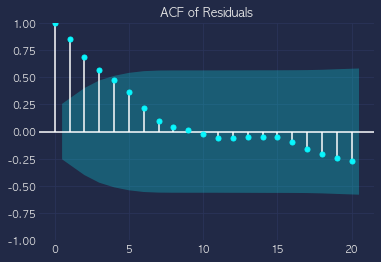

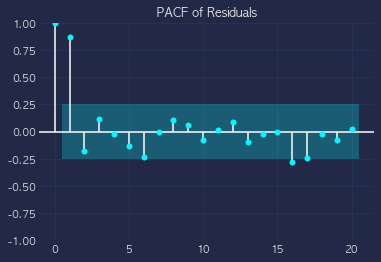

In [329]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 플롯
plot_acf(residuals, lags=20)
plt.title("ACF of Residuals")
plt.show()

# PACF 플롯
plot_pacf(residuals, lags=20)
plt.title("PACF of Residuals")
plt.show()

- 잔차에 자기상관성 존재. 시간의존적 요인(계절성, 트랜드)이 반영되어야 함. 여기선 제외

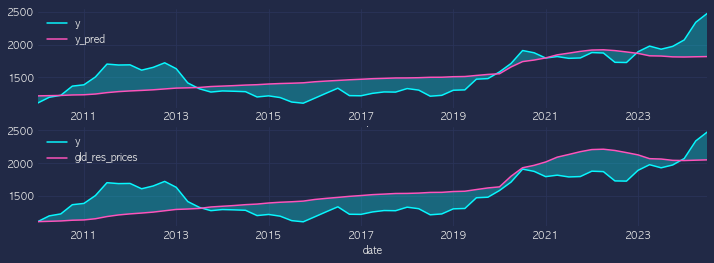

In [344]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,4))

df_yy = pd.DataFrame(data={
    'y':y,
    'y_pred':y_pred})

df_yy.plot(ax=axes[0])

# 잔차 계산
residuals = df_gld_mc['price/oz'] - (lr.coef_[0] * (data_m2 / data_gld).dropna()  + lr.intercept_)
axes[0].fill_between(x=y.index, y1=y, y2=y_pred, alpha=0.3)
axes[0].legend()

df_yy['y'].plot(ax=axes[1])
gld_res_prices.plot(ax=axes[1], label='gld_res_prices')
axes[1].fill_between(x=y.index, y1=gld_res_prices, y2=y, alpha=0.3)
axes[1].legend()


plt.show()


- 움직임 유사함 확인

## Step 4. 

### 3-2. 유동성 비율을 통한 비트코인 가격 추정, 실제 가격과 비교

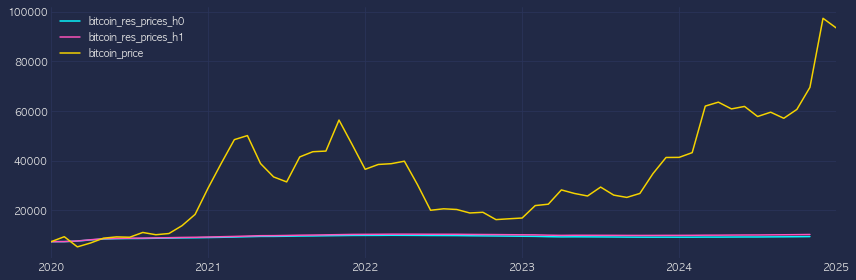

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

data_bitcoin_latest = (df_bitcoin_mc['supply']['2020':] / df_bitcoin_mc['supply']['2020':].iloc[0])
data_m2_latest = (m2['2020':] / m2['2020':].iloc[0])

bitcoin_res_prices_h0 = (data_m2_latest.resample('M').min() \
                        / data_bitcoin_latest.resample('M').min()).dropna() \
                        * df_bitcoin_mc['price']['2020':].iloc[0]
bitcoin_res_prices_h1 = data_m2_latest.resample('M').min() * df_bitcoin_mc['price']['2020':].iloc[0]

bitcoin_res_prices_h0.plot(ax=ax, label='bitcoin_res_prices_h0')
bitcoin_res_prices_h1.plot(ax=ax, label='bitcoin_res_prices_h1')
df_bitcoin_mc['price']['2020':].resample('M').min().plot(ax=ax, label='bitcoin_price')

plt.legend()
plt.tight_layout()
plt.show()

- 괴리가 심하다. 아직 비트코인 시총 커버리지가 낮은걸까
- 유동성 비율만으로는 설명력이 없음. 아직 가격이 충분히 올라오지 않은 것으로 보임. 금 시총까지 따라잡아야 하는가?
- 금/달러 유동성 비율이 금의 가격을 ㅅ시총이 낮아서 아직 따라잡을 상한이 높고, 

### 2-5. 금과 비트코인 가격 비교

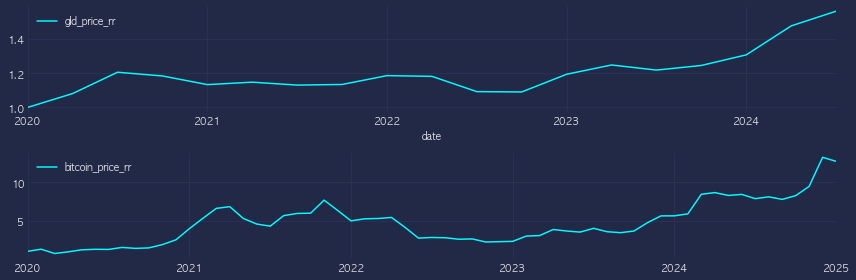

In [238]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,4))

gld_price_latest = df_gld_mc['price/oz']['2020':]
bitcoin_price_latest = df_bitcoin_mc['price']['2020':]

gld_price_rr = (gld_price_latest / gld_price_latest.iloc[0]).resample('M').min().dropna()
bitcoin_price_rr = (bitcoin_price_latest / bitcoin_price_latest.iloc[0]).resample('M').min().dropna()

gld_price_rr.plot(ax=axes[0], label='gld_price_rr')
bitcoin_price_rr.plot(ax=axes[1], label='bitcoin_price_rr')


axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

In [239]:
bitcoin_price_rr.iloc[-1] / gld_price_rr.iloc[-1]

8.136231161063387

In [240]:
pd.DataFrame(data={
    'gld_price_rr':gld_price_rr,
    'bitcoin_price_rr':bitcoin_price_rr
}).dropna().corr()

,gld_price_rr,bitcoin_price_rr
gld_price_rr,1.000000,0.695256
bitcoin_price_rr,0.695256,1.000000


- 2020년 이후 비트코인 가격 총 상승률이 금 대비 8배 수준으로 매우 가파르다.

### 2-6. 금과 비트코인 시총 비교

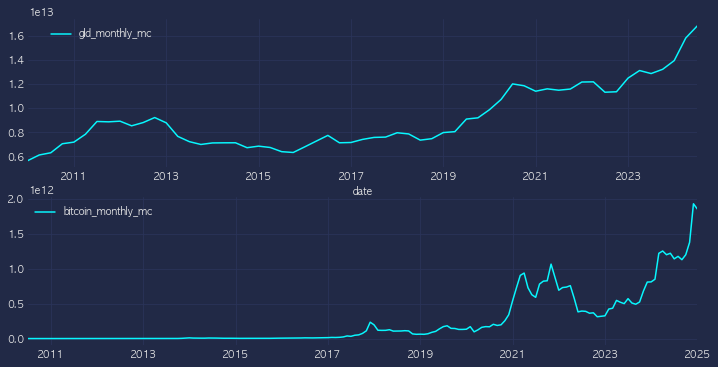

In [241]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,6))

gld_monthly_mc = df_gld_mc['market_cap'].resample('M').min().dropna()
bitcoin_monthly_mc = df_bitcoin_mc['market_cap'].resample('M').min().dropna()

gld_monthly_mc.plot(ax=axes[0], label='gld_monthly_mc')
bitcoin_monthly_mc.plot(ax=axes[1], label='bitcoin_monthly_mc')

axes[0].legend(bbox_to_anchor=(0.2,1))
axes[1].legend(bbox_to_anchor=(0.2,1))
plt.show()

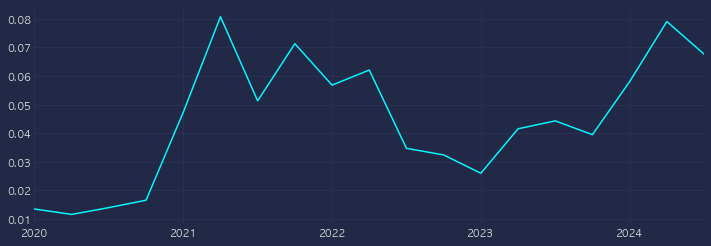

2020-01-31    0.013524
2020-04-30    0.011628
2020-07-31    0.014012
2020-10-31    0.016595
2021-01-31    0.047324
2021-04-30    0.080741
2021-07-31    0.051335
2021-10-31    0.071317
2022-01-31    0.056829
2022-04-30    0.062108
2022-07-31    0.034746
2022-10-31    0.032427
2023-01-31    0.026018
2023-04-30    0.041564
2023-07-31    0.044332
2023-10-31    0.039512
2024-01-31    0.058071
2024-04-30    0.079067
2024-07-31    0.067672
Name: market_cap, dtype: float64

0.1099782142543127


In [288]:
bitcoin_gld_full_mc_ratio = (bitcoin_monthly_mc / gld_monthly_mc).dropna()['2020':]
bitcoin_gld_latest_mc_ratio = bitcoin_monthly_mc.iloc[-1] / gld_monthly_mc.iloc[-1]

plt.figure(figsize=(12,4))
bitcoin_gld_full_mc_ratio.plot(label='bitcoin_gld_full_mc_ratio')

plt.show()

display(bitcoin_gld_full_mc_ratio)
print(bitcoin_gld_latest_mc_ratio)

- 최근 기준 비트코인 시총은 금 시총의 1/10

### 2-7. 시총 비율 역산한 비트코인 적정가 계산

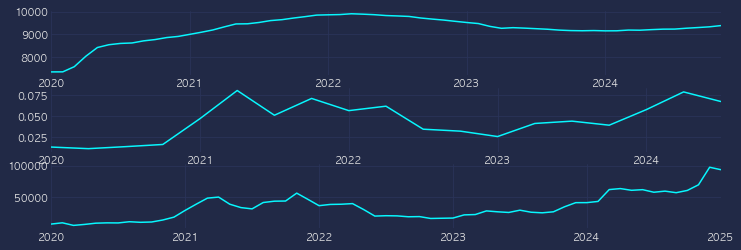

In [281]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12,4))

bitcoin_res_prices_h0.plot(ax=axes[0], label='bitcoin_res_prices_h0')
bitcoin_gld_full_mc_ratio['2020':].dropna().plot(ax=axes[1], label='bitcoin_res_prices_h0 * bitcoin_gld_full_mc_ratio')
df_bitcoin_mc['price']['2020':].resample('M').min().plot(ax=axes[2], label='bitcoin_price')

plt.show()

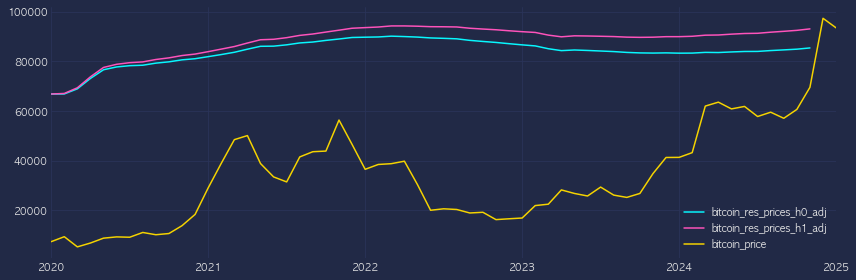

In [282]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

data_bitcoin_latest = (df_bitcoin_mc['supply']['2020':] / df_bitcoin_mc['supply']['2020':].iloc[0])
data_m2_latest = (m2['2020':] / m2['2020':].iloc[0])

bitcoin_res_prices_h0_adj = (data_m2_latest.resample('M').min() \
                            / data_bitcoin_latest.resample('M').min()).dropna() \
                            * df_bitcoin_mc['price']['2020':].iloc[0] \
                            / bitcoin_gld_latest_mc_ratio
bitcoin_res_prices_h1_adj = data_m2_latest.resample('M').min() \
                            * df_bitcoin_mc['price']['2020':].iloc[0] \
                            / bitcoin_gld_latest_mc_ratio

bitcoin_res_prices_h0_adj.plot(ax=ax, label='bitcoin_res_prices_h0_adj')
bitcoin_res_prices_h1_adj.plot(ax=ax, label='bitcoin_res_prices_h1_adj')
df_bitcoin_mc['price']['2020':].resample('M').min().plot(ax=ax, label='bitcoin_price')

plt.legend()
plt.tight_layout()
plt.show()

단순 통화-비트코인 유동성 비율로 비트코인 가격 상승률을 설명할 수 없고, 
시총 비율이 금과 동일하다고 가정하면, 위 차트와 같이 움직일 것이라고 추정해볼 수 있다. 그리고 2025년 기점 추정값과 실제값이 유사한 수준에 도달해있다.

- 현재 가격은 비트코인 시총이 금 시총만큼 갈 것이라는 기대가 선반영된 것인가?

In [404]:
(data_m2 / data_gld).dropna()

2010-01-01    1.000000
2010-04-01    1.004373
2010-07-01    1.009210
2010-10-01    1.019217
2011-01-01    1.023418
2011-04-01    1.039732
2011-07-01    1.069753
2011-10-01    1.091733
2012-01-01    1.106275
2012-04-01    1.117750
2012-07-01    1.130679
2012-10-01    1.149176
2013-01-01    1.167626
2013-04-01    1.173124
2013-07-01    1.181155
2013-10-01    1.201327
2014-01-01    1.211155
2014-04-01    1.220876
2014-07-01    1.232970
2014-10-01    1.241113
2015-01-01    1.255933
2015-04-01    1.266129
2015-07-01    1.272852
2015-10-01    1.281756
2016-01-01    1.304187
2016-04-01    1.319411
2016-07-01    1.332809
2016-10-01    1.347026
2017-01-01    1.358007
2017-04-01    1.370572
2017-07-01    1.377948
2017-10-01    1.386319
2018-01-01    1.387415
2018-04-01    1.392027
2018-07-01    1.400844
2018-10-01    1.402065
2019-01-01    1.413273
2019-04-01    1.417352
2019-07-01    1.440511
2019-10-01    1.462589
2020-01-01    1.477363
2020-04-01    1.623354
2020-07-01    1.739616
2020-10-01 

In [406]:
(data_m2_latest.resample('M').min() / data_bitcoin_latest.resample('M').min()).dropna()

2020-01-31    1.000000
2020-02-29    1.000289
2020-03-31    1.031302
2020-04-30    1.093990
2020-05-31    1.146271
2020-06-30    1.163088
2020-07-31    1.170842
2020-08-31    1.173562
2020-09-30    1.186141
2020-10-31    1.194002
2020-11-30    1.205993
2020-12-31    1.212808
2021-01-31    1.225262
2021-02-28    1.237851
2021-03-31    1.251579
2021-04-30    1.270263
2021-05-31    1.287681
2021-06-30    1.288555
2021-07-31    1.296496
2021-08-31    1.307863
2021-09-30    1.313399
2021-10-31    1.323175
2021-11-30    1.331569
2021-12-31    1.340789
2022-01-31    1.342486
2022-02-28    1.343920
2022-03-31    1.348738
2022-04-30    1.346313
2022-05-31    1.343145
2022-06-30    1.338075
2022-07-31    1.335656
2022-08-31    1.332695
2022-09-30    1.323420
2022-10-31    1.316848
2022-11-30    1.310879
2022-12-31    1.303352
2023-01-31    1.296306
2023-02-28    1.290042
2023-03-31    1.273051
2023-04-30    1.261551
2023-05-31    1.265385
2023-06-30    1.262576
2023-07-31    1.259254
2023-08-31 